# Create overview figures
This notebook creates daily overview figures and also shows how to work with the level2 data

Mistral: 10GB shared resources are needed for plotting all figures (savefig: True)

## Setup

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../helpers/")

In [3]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')
import os
import tqdm
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
os.environ['PROJ_LIB'] = "~/anaconda3/pkgs/proj4-6.0.0-h2cc77ee_1/share/proj"
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import Normalize
import dask.array as da
import xarray as xr
import zarr
from helpers import *

In [4]:
mode = 'daily'

# Level1 filename
level1_dataset_local = '../processed_data/EUREC4A_ManualClassifications_l1_anonymized.nc'
level1_dataset_zenodo = 'https://zenodo.org/api/files/994b37c9-2c3c-4d3b-add2-ee149093a0f7/EUREC4A_ManualCloudClassification_l1.zip'

# Level2 filename
level2_dataset_local = '../processed_data/EUREC4A_ManualClassifications_l2.zarr'.format(mode=mode)
level2_dataset_zenodo = 'https://zenodo.org/api/files/994b37c9-2c3c-4d3b-add2-ee149093a0f7/EUREC4A_ManualCloudClassification_l2.zip'

# Level3 filename
level3_dataset_local = '../processed_data/EUREC4A_ManualClassifications_l3_{spectrum}_{mode}.zarr'
level3_dataset_zenodo = 'https://zenodo.org/api/files/994b37c9-2c3c-4d3b-add2-ee149093a0f7/EUREC4A_ManualCloudClassification_l3_{spectrum}_{mode}.zip'

# Classified images
path_to_MODISVIS_local = '../source_images/EUREC4A_VIS_workflow/EUREC4A_MODIS_AQUA-VIS/'
path_to_GOES16_local = '../source_images/EUREC4A_IR_workflow/'
path_to_ICON_local = '../source_images/EUREC4A_ICON_alb_workflow/'
path_to_images_zenodo = 'https://zenodo.org/api/files/994b37c9-2c3c-4d3b-add2-ee149093a0f7/EUREC4A_SourceImages.zip'

savefig = False # True: loop through all images and save heatmap, otherwise show first day inline
savefig4 = True # True: Only plot 2020-02-12 for Fig.4 in manuscript

## Prepare data

In [5]:
# Load level 1 data
try:
    # Try to find file locally
    ds_l1 = xr.open_dataset(level1_dataset_local)
except (KeyError, FileNotFoundError):
    # Retrieve file from zenodo archive
    import minato
    from io import BytesIO
    import zipfile
    lf = minato.cached_path(f"{level1_dataset_zenodo}")  # Download file
    z=zipfile.ZipFile(lf.as_posix())  # Open zip
    b=BytesIO(z.read('processed_data/EUREC4A_ManualClassifications_l1_anonymized.nc')) # Unzip
    ds_l1 = xr.open_dataset(b, engine='h5netcdf')
df_l1 = ds_l1.to_dataframe()

In [6]:
# Load level 2 data
if os.path.exists(level2_dataset_local):
    # Open file for reading
    ds_l2 = xr.open_zarr(level2_dataset_local)
elif os.path.exists(level2_dataset_local+'.zip'):
    print('Please unzip {} first an rerun.'.format(level2_dataset_local+'.zip'))
    sys.exit()
else:
    print("Using dataset available at zenodo. To create a new version, please run create_level2.py.")
    ds_l2 = xr.open_zarr(f"zip://processed_data/EUREC4A_ManualClassifications_l2.zarr::{level2_dataset_zenodo}")

Using dataset available at zenodo. To create a new version, please run create_level2.py.


## Start plotting

### Daily classification frequency based on the workflow EUREC4A (VIS)
Heatmap of all classifications based on MODIS visible images only (GOES16 is ignored here)

In [7]:
def get_image(fn, workflow):
    file_local = f"../source_images/{workflow}/"+filename
    file_remote = f"source_images/{workflow}/"+filename
    if os.path.exists(file_local):
        # File is local
        img = plt.imread(file_local)
    else:
        import fsspec
        m = fsspec.get_mapper("zip::https://zenodo.org/api/files/994b37c9-2c3c-4d3b-add2-ee149093a0f7/EUREC4A_SourceImages.zip")
        b=BytesIO(m[file_remote])
        img = plt.imread(b, format='jpeg')
    return img

  0%|                                                                                                                                                    | 0/47 [00:00<?, ?it/s]

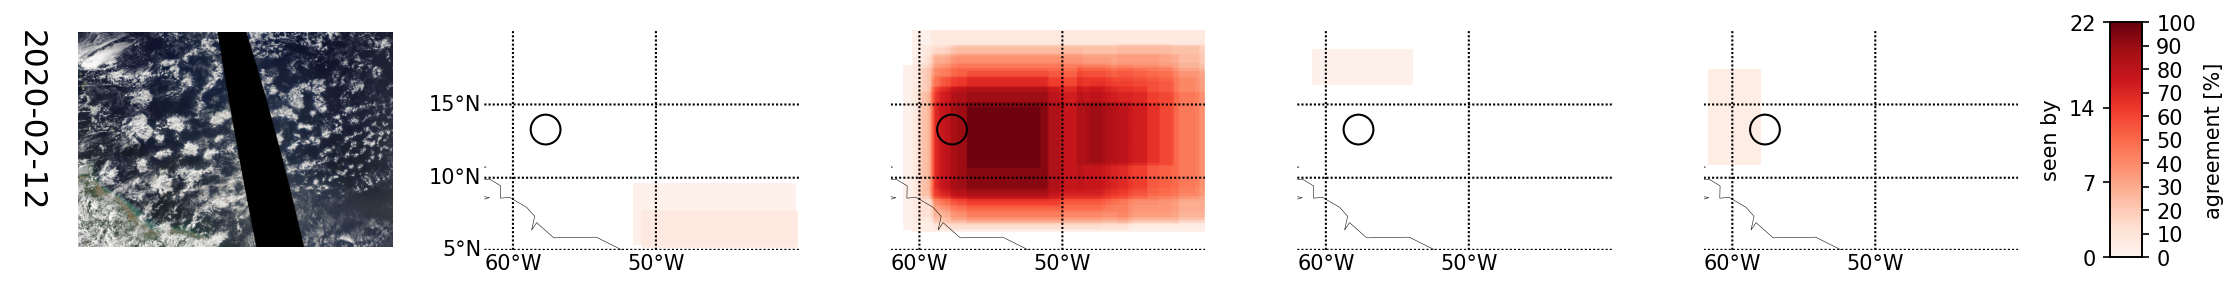

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 36/47 [00:23<00:07,  1.51it/s]


In [8]:
lons = np.linspace(-62,-40,2200)
lats = np.linspace(20,5,1500)

lat_grid, lon_grid = np.meshgrid(lats, lons)

workflow = 'EUREC4A (VIS)'
workflow_subpath = "EUREC4A_VIS_workflow/EUREC4A_MODIS_AQUA-VIS"
instrument = 'MODIS'

for d, (date, date_df) in enumerate(tqdm.tqdm(df_l1.groupby(df_l1['date'].dt.date))):
    if savefig4:
        if date != dt.datetime(2020,2,12).date(): continue
    date_arr = np.zeros((len(np.unique(date_df.user_id)),
                         ds_l2.mask.shape[1],
                         ds_l2.mask.shape[2],
                         4
                        ), dtype=float)
    date_df_sel = date_df.loc[np.logical_and(~date_df.already_seen.astype(bool),
                                             np.logical_and(date_df.workflow_name == workflow ,
                                                            date_df.instrument == instrument))]
    for u, (user_id, user_df) in enumerate(date_df_sel.groupby('user_id')):
        class_ids = user_df.classification_id
        class_ids = np.unique(class_ids)
        user_arr_ = ds_l2.mask.sel({'classification_id':class_ids})
        user_arr = np.bitwise_and(user_arr_.expand_dims({'pattern':4},3).fillna(0).astype(int).values, np.array([1,2,4,8])[np.newaxis,np.newaxis,np.newaxis,:]).astype('bool')

        user_arr = np.mean(user_arr,axis=0)  # along classification_id

        date_arr[u, :,:,:] = user_arr
    nb_users = len(np.unique(date_df_sel.user_id))

    freq = np.nan_to_num((np.sum(date_arr[:,:,:,:], axis=0)/nb_users))
    user_w_classifications = freq*len(np.unique(date_df_sel.user_id))
    user_w_classifications[user_w_classifications==0] = np.nan
    date_as_datetime = dt.datetime.combine(date, dt.datetime.min.time())
        
    filenames = np.unique(date_df_sel.fn.values)
    filename = find_filename(filenames)
    
    if plt.isinteractive(): # Disable interactivity so that plt.close() frees memory
        plt.ioff()
    
    fig, ax = plt.subplots(1,6,figsize=(15,2), dpi=150, gridspec_kw={'width_ratios':[1,1,1,1,1,0.1]})

    norm = Normalize(vmin = 0, vmax = len(np.unique(date_df_sel.user_id)), clip = False)

    for p in range(1,5):
        m = Basemap(ax=ax.flat[p], projection='merc',llcrnrlat=5,urcrnrlat=20,\
            llcrnrlon=-62,urcrnrlon=-40,lat_ts=20,resolution='c')
        m.drawcoastlines(linewidth=0.25)
        if savefig is False or savefig4:
            if p == 1:
                lat_labels = [1,0,0,0]
                lon_labels = [0,0,0,1]
            else:
                lat_labels = [0,0,0,0]
                lon_labels = [0,0,0,1]
        else:
            lat_labels = [0,0,0,0]
            lon_labels = [0,0,0,0]
        m.drawparallels(np.arange(5,20,5),labels=lat_labels)
        m.drawmeridians(np.arange(-60,-40,10),labels=lon_labels)

        cs = m.imshow(user_w_classifications[:,:,p-1].T,
                      origin='upper', cmap='Reds', norm=norm,
                      extent=[-62,-40,5,20])
        # HALO circle
        x,y=m(-57.717, 13.3)
        x2,y2 = m(-57.717,13.3+1.011) 
        circle1 = plt.Circle((x, y), y2-y, color='black',fill=False)
        ax.flat[p].add_patch(circle1)
        ax.flat[p].axis('off')

    ax.flat[0].annotate(date, (-0.2,0.2), rotation=-90, xycoords='axes fraction', fontsize=15)

    # Show AQUA image:
    img = get_image(filename,workflow_subpath)
    ax.flat[0].imshow(img)
    ax.flat[0].axis('off')
    
    cax = ax.flat[5]
    sm = plt.cm.ScalarMappable(cmap='Reds', norm=norm)
    sm._A = []
    cb = plt.colorbar(sm, cax=cax)
    cb.set_label('Users')
    
    cax2 = cax.twinx()
    user_ticks=np.linspace(0, nb_users,4)
    per_ticks=np.linspace(0,100,11).astype(int)
    cb.set_ticks(user_ticks.astype(int))
    cb.set_label("seen by")
    cb.ax.yaxis.set_label_position("left")
    cax2.set_ylim(0,100)
    cax2.set_yticks(per_ticks)
    cax2.set_yticklabels(per_ticks)
    cax2.set_ylabel("agreement [%]")
    
    plt.tight_layout()
    if savefig and (savefig4 is False):
        plt.savefig('../figures/VIS_dailyaverage/EUREC4A_ManualClassifications_MODISAverage_{}_{}.pdf'.format(date.strftime('%Y%m%d'), 'instant'),
                dpi=150, bbox_inches='tight',pad=0)
        plt.close('all')
    elif savefig and savefig4:
        plt.savefig('../figures/VIS_dailyaverage/EUREC4A_ManualClassifications_MODISAverage_{}_{}_Fig4.pdf'.format(date.strftime('%Y%m%d'), 'instant'),
                dpi=150, bbox_inches='tight',pad=0)
        plt.close('all')
        break
    else:
        plt.show()
        break

### Daily classification frequency based on ICON albedo simulation data

  0%|                                                                                                                                                    | 0/47 [00:00<?, ?it/s]

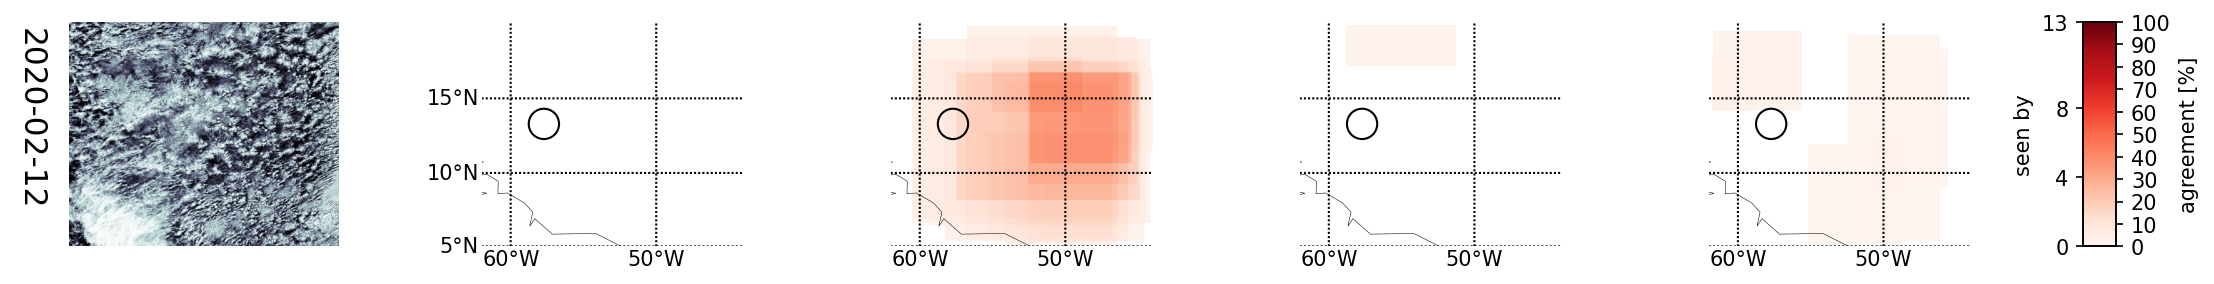

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 36/47 [00:21<00:06,  1.68it/s]


In [9]:
lons = np.linspace(-62,-44,882)
lats = np.linspace(20,5,735)

lat_grid, lon_grid = np.meshgrid(lats, lons)

workflow = 'EUREC4A (ICON; albedo)'
workflow_subpath = "EUREC4A_ICON_alb_workflow"
instrument = 'n/a'

for d, (date, date_df) in enumerate(tqdm.tqdm(df_l1.groupby(df_l1['date'].dt.date))):
    if d < 9 or d > 44: continue  # no simulation output for the first days
    if savefig4:
        if date != dt.datetime(2020,2,12).date(): continue
    date_arr = np.zeros((len(np.unique(date_df.user_id)),
                         ds_l2.mask.shape[1],
                         ds_l2.mask.shape[2],
                         4
                        ), dtype=float)
    date_df_sel = date_df.loc[np.logical_and(~date_df.already_seen.astype(bool),
                                             np.logical_and(date_df.workflow_name == workflow ,
                                                            date_df.instrument == instrument))]
    for u, (user_id, user_df) in enumerate(date_df_sel.groupby('user_id')):
        class_ids = user_df.classification_id
        class_ids = np.unique(class_ids)
        user_arr_ = ds_l2.mask.sel({'classification_id':class_ids})
        user_arr = np.bitwise_and(user_arr_.expand_dims({'pattern':4},3).fillna(0).astype(int).values, np.array([1,2,4,8])[np.newaxis,np.newaxis,np.newaxis,:]).astype('bool')

        user_arr = np.mean(user_arr,axis=0)  # along classification_id

        date_arr[u, :,:,:] = user_arr
    nb_users = len(np.unique(date_df_sel.user_id))

    freq = np.nan_to_num((np.sum(date_arr[:,:,:,:], axis=0)/nb_users))
    user_w_classifications = freq*len(np.unique(date_df_sel.user_id))
    user_w_classifications[user_w_classifications==0] = np.nan
    date_as_datetime = dt.datetime.combine(date, dt.datetime.min.time())
        
    filenames = np.unique(date_df_sel.fn.values)
    filename = find_filename(filenames, 'ICON_albedo')

    if plt.isinteractive(): # Disable interactivity so that plt.close() frees memory
        plt.ioff()

    fig, ax = plt.subplots(1,6,figsize=(15,2), dpi=150, gridspec_kw={'width_ratios':[1,1,1,1,1,0.1]})

    norm = Normalize(vmin = 0, vmax = len(np.unique(date_df_sel.user_id)), clip = False)

    for p in range(1,5):
        m = Basemap(ax=ax.flat[p], projection='merc',llcrnrlat=5,urcrnrlat=20,\
            llcrnrlon=-62,urcrnrlon=-44,lat_ts=20,resolution='c')
        m.drawcoastlines(linewidth=0.25)
        if savefig is False or savefig4:
            if p == 1:
                lat_labels = [1,0,0,0]
                lon_labels = [0,0,0,1]
            else:
                lat_labels = [0,0,0,0]
                lon_labels = [0,0,0,1]
        else:
            lat_labels = [0,0,0,0]
            lon_labels = [0,0,0,0]
        m.drawparallels(np.arange(5,20,5),labels=lat_labels)
        m.drawmeridians(np.arange(-60,-40,10),labels=lon_labels)

        cs = m.imshow(user_w_classifications[:882,:735,p-1].T,
                      origin='upper', cmap='Reds', norm=norm,
                      extent=[-62,-44,5,20])
        # HALO circle
        x,y=m(-57.717, 13.3)
        x2,y2 = m(-57.717,13.3+1.011) 
        circle1 = plt.Circle((x, y), y2-y, color='black',fill=False)
        ax.flat[p].add_patch(circle1)
        ax.flat[p].axis('off')

    ax.flat[0].annotate(date, (-0.2,0.2), rotation=-90, xycoords='axes fraction', fontsize=15)

    # Show AQUA image:
    img = get_image(filename,workflow_subpath)
    ax.flat[0].imshow(img)
    ax.flat[0].axis('off')
    
    cax = ax.flat[5]
    sm = plt.cm.ScalarMappable(cmap='Reds', norm=norm)
    sm._A = []
    cb = plt.colorbar(sm, cax=cax)
    cb.set_label('Users')
    
    cax2 = cax.twinx()
    user_ticks=np.linspace(0, nb_users,4)
    per_ticks=np.linspace(0,100,11).astype(int)
    cb.set_ticks(user_ticks.astype(int))
    cb.set_label("seen by")
    cb.ax.yaxis.set_label_position("left")
    cax2.set_ylim(0,100)
    cax2.set_yticks(per_ticks)
    cax2.set_yticklabels(per_ticks)
    cax2.set_ylabel("agreement [%]")
    
    plt.tight_layout()
    if savefig and (savefig4 is False):
        plt.savefig('../figures/ICON_alb_dailyaverage/EUREC4A_ManualClassifications_ICONDailyAverage_{}.pdf'.format(date.strftime('%Y%m%d')),
                dpi=150, bbox_inches='tight',pad=0)
        plt.close('all')
    elif savefig and savefig4:
        plt.savefig('../figures/ICON_alb_dailyaverage/EUREC4A_ManualClassifications_ICONDailyAverage_{}_Fig4.pdf'.format(date.strftime('%Y%m%d')),
                dpi=150, bbox_inches='tight',pad=0)
        plt.close('all')
        break
    else:
        plt.show()
        break

### Daily classification frequency based on the workflow EUREC4A (IR)

  0%|                                                                                                                                                    | 0/47 [00:00<?, ?it/s]

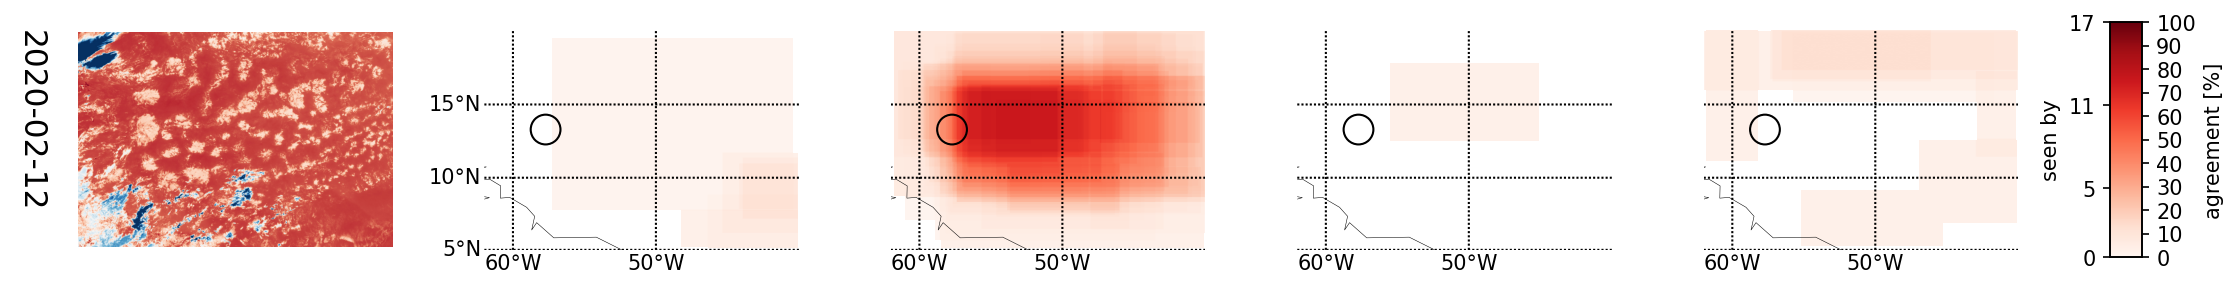

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 36/47 [00:41<00:12,  1.14s/it]


In [10]:
lons = np.linspace(-62,-40,2200)
lats = np.linspace(20,5,1500)

lat_grid, lon_grid = np.meshgrid(lats, lons)

workflow = 'EUREC4A (IR)'
workflow_subpath = 'EUREC4A_IR_workflow'
instrument = 'ABI'

for d, (date, date_df) in enumerate(tqdm.tqdm(df_l1.groupby(df_l1['date'].dt.date))):
    if savefig4:
        if date != dt.datetime(2020,2,12).date(): continue
    date_arr = np.zeros((len(np.unique(date_df.user_id)),
                         ds_l2.mask.shape[1],
                         ds_l2.mask.shape[2],
                         4
                        ), dtype=float)
    date_df_sel = date_df.loc[np.logical_and(~date_df.already_seen.astype(bool),
                                             np.logical_and(date_df.workflow_name == workflow ,
                                                            date_df.instrument == instrument))]
    for u, (user_id, user_df) in enumerate(date_df_sel.groupby('user_id')):
        class_ids = user_df.classification_id
        class_ids = np.unique(class_ids)
        user_arr_ = ds_l2.mask.sel({'classification_id':class_ids})
        user_arr = np.bitwise_and(user_arr_.expand_dims({'pattern':4},3).fillna(0).astype(int).values, np.array([1,2,4,8])[np.newaxis,np.newaxis,np.newaxis,:]).astype('bool')

        user_arr = np.mean(user_arr,axis=0)  # along classification_id

        date_arr[u, :,:,:] = user_arr
    nb_users = len(np.unique(date_df_sel.user_id))

    freq = np.nan_to_num((np.sum(date_arr[:,:,:,:], axis=0)/nb_users))
    user_w_classifications = freq*len(np.unique(date_df_sel.user_id))
    user_w_classifications[user_w_classifications==0] = np.nan
    date_as_datetime = dt.datetime.combine(date, dt.datetime.min.time())
        
    filenames = np.unique(date_df_sel.fn.values)
    filename = find_filename(filenames, date.strftime('GOES16_C13_%Y%m%d_1600'))

    if plt.isinteractive(): # Disable interactivity so that plt.close() frees memory
        plt.ioff()
    
    if filename is None:
        filename = date.strftime('GOES16_C13_%Y%m%d_1800.jpeg')
    if filename is None: continue
    fig, ax = plt.subplots(1,6,figsize=(15,2), dpi=150, gridspec_kw={'width_ratios':[1,1,1,1,1,0.1]})

    norm = Normalize(vmin = 0, vmax = len(np.unique(date_df_sel.user_id)), clip = False)

    for p in range(1,5):
        m = Basemap(ax=ax.flat[p], projection='merc',llcrnrlat=5,urcrnrlat=20,\
            llcrnrlon=-62,urcrnrlon=-40,lat_ts=20,resolution='c')
        m.drawcoastlines(linewidth=0.25)
        if savefig is False or savefig4:
            if p == 1:
                lat_labels = [1,0,0,0]
                lon_labels = [0,0,0,1]
            else:
                lat_labels = [0,0,0,0]
                lon_labels = [0,0,0,1]
        else:
            lat_labels = [0,0,0,0]
            lon_labels = [0,0,0,0]
        m.drawparallels(np.arange(5,20,5),labels=lat_labels)
        m.drawmeridians(np.arange(-60,-40,10),labels=lon_labels)

        cs = m.imshow(user_w_classifications[:,:,p-1].T,
                      origin='upper', cmap='Reds', norm=norm,
                      extent=[-62,-40,5,20])
        # HALO circle
        x,y=m(-57.717, 13.3)
        x2,y2 = m(-57.717,13.3+1.011) 
        circle1 = plt.Circle((x, y), y2-y, color='black',fill=False)
        ax.flat[p].add_patch(circle1)
        ax.flat[p].axis('off')

    ax.flat[0].annotate(date, (-0.2,0.2), rotation=-90, xycoords='axes fraction', fontsize=15)

    # Show GOES16 ABI image:
    img = get_image(filename,workflow_subpath)
    ax.flat[0].imshow(img)
    ax.flat[0].axis('off')
    
    cax = ax.flat[5]
    sm = plt.cm.ScalarMappable(cmap='Reds', norm=norm)
    sm._A = []
    cb = plt.colorbar(sm, cax=cax)
    cb.set_label('Users')
    
    cax2 = cax.twinx()
    user_ticks=np.linspace(0, nb_users,4)
    per_ticks=np.linspace(0,100,11).astype(int)
    cb.set_ticks(user_ticks.astype(int))
    cb.set_label("seen by")
    cb.ax.yaxis.set_label_position("left")
    cax2.set_ylim(0,100)
    cax2.set_yticks(per_ticks)
    cax2.set_yticklabels(per_ticks)
    cax2.set_ylabel("agreement [%]")
    
    plt.tight_layout()

    if savefig and (savefig4 is False):
        plt.savefig('../figures/IR_dailyaverage/EUREC4A_ManualClassifications_IRDailyAverage_{}.pdf'.format(date.strftime('%Y%m%d')),
                dpi=150, bbox_inches='tight',pad=0)
        plt.close('all')
    elif savefig and savefig4:
        plt.savefig('../figures/IR_dailyaverage/EUREC4A_ManualClassifications_IRDailyAverage_{}_Fig4.pdf'.format(date.strftime('%Y%m%d')),
                dpi=150, bbox_inches='tight',pad=0)
        plt.close('all')
        break
    else:
        plt.show()
        break

## Frequency maps based on level 3 products

In [11]:
# Load level 3 data
spectrum='VIS'
if os.path.exists(level3_dataset_local.format(spectrum=spectrum,mode=mode)):
    # Open file for reading
    ds_l3 = xr.open_zarr(level3_dataset_local.format(spectrum=spectrum,mode=mode))
elif os.path.exists(level3_dataset_local+'.zip'):
    print('Please unzip {} first an rerun.'.format(level3_dataset_local+'.zip'))
    sys.exit()
else:
    print("Using dataset available at zenodo. To create a new version, please run create_level3.py.")
    ds_l3 = xr.open_zarr(f"zip://processed_data/EUREC4A_ManualClassifications_l3_{spectrum}_{mode}.zarr::{level3_dataset_zenodo.format(spectrum=spectrum, mode=mode)}")

Using dataset available at zenodo. To create a new version, please run create_level3.py.


  0%|                                                                                                                                                    | 0/47 [00:00<?, ?it/s]

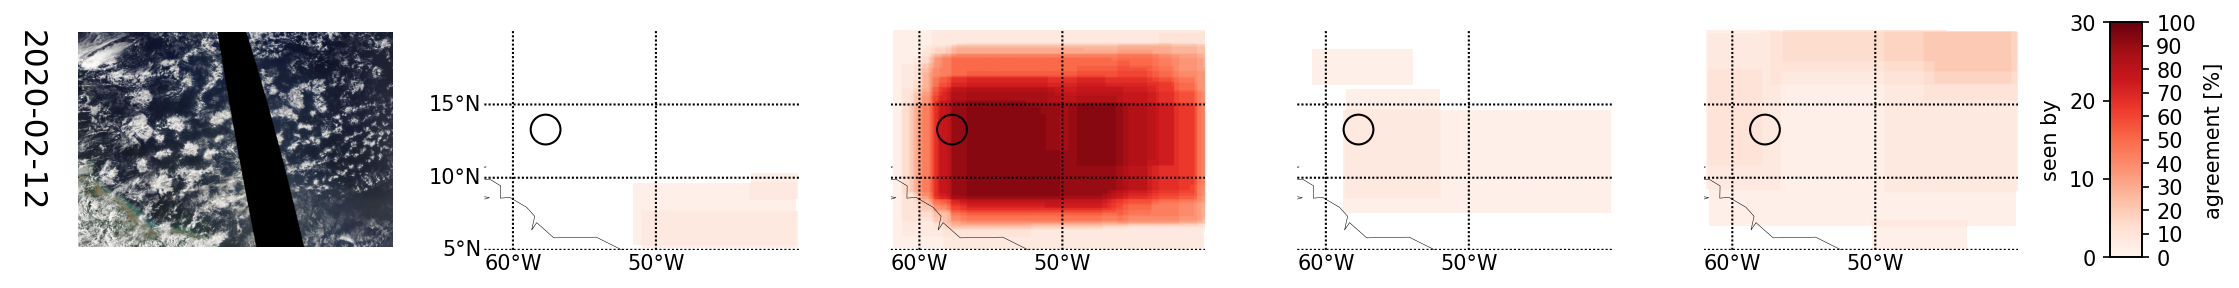

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 36/47 [00:10<00:03,  3.55it/s]


In [12]:
lons = np.linspace(-62,-40,2200)
lats = np.linspace(20,5,1500)

lat_grid, lon_grid = np.meshgrid(lats, lons)

workflow = 'EUREC4A (VIS)'
workflow_subpath = "EUREC4A_VIS_workflow/EUREC4A_MODIS_AQUA-VIS"
instrument = 'MODIS'

for d, (date, date_df) in enumerate(tqdm.tqdm(df_l1.groupby(df_l1['date'].dt.date))):
    if savefig4:
        if date != dt.datetime(2020,2,12).date(): continue
    date_arr = np.zeros((
                         ds_l3.freq.shape[1],
                         ds_l3.freq.shape[2],
                         ds_l3.freq.shape[3]
                        ), dtype=float)
    date_df_sel = date_df.loc[np.logical_and(~date_df.already_seen.astype(bool),
                                             np.logical_and(date_df.workflow_name == workflow ,
                                                            date_df.instrument == instrument))]
    date_as_datetime = dt.datetime.combine(date, dt.datetime.min.time())
    date_arr[:,:,:] = ds_l3.freq.sel(date=date_as_datetime)
    nb_users = ds_l3.nb_users.sel(date=date_as_datetime).compute()
    user_w_classifications = date_arr*nb_users.values
        
    filenames = np.unique(date_df_sel.fn.values)
    filename = find_filename(filenames)
    
    if plt.isinteractive(): # Disable interactivity so that plt.close() frees memory
        plt.ioff()
    
    fig, ax = plt.subplots(1,6,figsize=(15,2), dpi=150, gridspec_kw={'width_ratios':[1,1,1,1,1,0.1]})
#     plt.suptitle(date,y=1.1)
#     norm = Normalize(vmin = 0, vmax = len(np.unique(date_df_sel.user_id)), clip = False)
    norm = Normalize(vmin = 0, vmax = nb_users, clip = False)
    for p in range(1,5):
        m = Basemap(ax=ax.flat[p], projection='merc',llcrnrlat=5,urcrnrlat=20,\
            llcrnrlon=-62,urcrnrlon=-40,lat_ts=20,resolution='c')
        m.drawcoastlines(linewidth=0.25)
        if savefig is False or savefig4:
            if p == 1:
                lat_labels = [1,0,0,0]
                lon_labels = [0,0,0,1]
            else:
                lat_labels = [0,0,0,0]
                lon_labels = [0,0,0,1]
        else:
            lat_labels = [0,0,0,0]
            lon_labels = [0,0,0,0]
        m.drawparallels(np.arange(5,20,5),labels=lat_labels)
        m.drawmeridians(np.arange(-60,-40,10),labels=lon_labels)
#         ax.flat[p].set_title(pattern_dic_inv[p-1])
#         x, y = m(lon_grid, lat_grid)
        cs = m.imshow(user_w_classifications[:,:,p-1].T,
                      origin='upper', cmap='Reds', norm=norm,
                      extent=[-62,-40,5,20])
        # HALO circle
        x,y=m(-57.717, 13.3)
        x2,y2 = m(-57.717,13.3+1.011) 
        circle1 = plt.Circle((x, y), y2-y, color='black',fill=False)
        ax.flat[p].add_patch(circle1)
        ax.flat[p].axis('off')

    ax.flat[0].annotate(date, (-0.2,0.2), rotation=-90, xycoords='axes fraction', fontsize=15)

    # Show AQUA image:
    img = get_image(filename,workflow_subpath)
    ax.flat[0].imshow(img)
    ax.flat[0].axis('off')
    
    cax = ax.flat[5]
    sm = plt.cm.ScalarMappable(cmap='Reds', norm=norm)
    sm._A = []
    cb = plt.colorbar(sm, cax=cax)
    cb.set_label('Users')
    
    cax2 = cax.twinx()
    user_ticks=np.linspace(0, nb_users,4)
    per_ticks=np.linspace(0,100,11).astype(int)
    cb.set_ticks(user_ticks.astype(int))
    cb.set_label("seen by")
    cb.ax.yaxis.set_label_position("left")
    cax2.set_ylim(0,100)
    cax2.set_yticks(per_ticks)
    cax2.set_yticklabels(per_ticks)
    cax2.set_ylabel("agreement [%]")
    
    plt.tight_layout()
    if savefig and (savefig4 is False):
        plt.savefig('../figures/VIS_dailyaverage/EUREC4A_ManualClassifications_MODISAverage_{}.pdf'.format(date.strftime('%Y%m%d')),
                dpi=150, bbox_inches='tight',pad=0)
        plt.close('all')
    elif savefig and savefig4:
        plt.savefig('../figures/VIS_dailyaverage/EUREC4A_ManualClassifications_MODISAverage_{}_Fig4.pdf'.format(date.strftime('%Y%m%d')),
                dpi=150, bbox_inches='tight',pad=0)
        plt.close('all')
        break
    else:
        plt.show()
        break

In [13]:
# Load level 3 data
spectrum='IR'
if os.path.exists(level3_dataset_local.format(spectrum=spectrum,mode=mode)):
    # Open file for reading
    ds_l3 = xr.open_zarr(level3_dataset_local.format(spectrum=spectrum,mode=mode))
elif os.path.exists(level3_dataset_local+'.zip'):
    print('Please unzip {} first an rerun.'.format(level3_dataset_local+'.zip'))
    sys.exit()
else:
    print("Using dataset available at zenodo. To create a new version, please run create_level3.py.")
    ds_l3 = xr.open_zarr(f"zip://processed_data/EUREC4A_ManualClassifications_l3_{spectrum}_{mode}.zarr::{level3_dataset_zenodo.format(spectrum=spectrum, mode=mode)}")

Using dataset available at zenodo. To create a new version, please run create_level3.py.


  0%|                                                                                                                                                    | 0/47 [00:00<?, ?it/s]

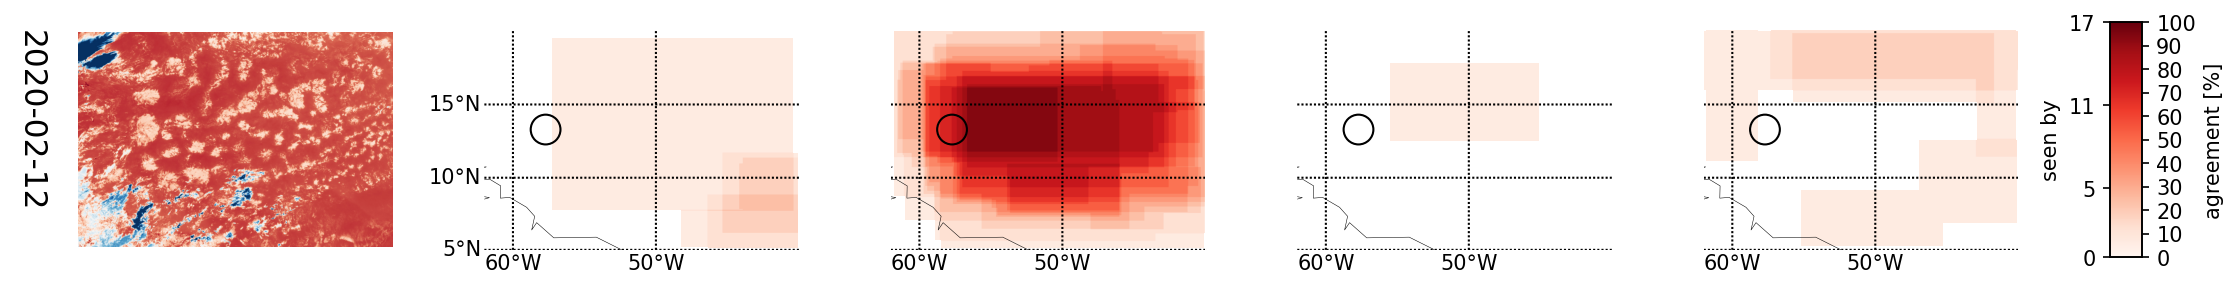

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 36/47 [00:07<00:02,  4.82it/s]


In [14]:
lons = np.linspace(-62,-40,2200)
lats = np.linspace(20,5,1500)

lat_grid, lon_grid = np.meshgrid(lats, lons)

workflow = 'EUREC4A (IR)'
workflow_subpath = 'EUREC4A_IR_workflow'
instrument = 'ABI'

for d, (date, date_df) in enumerate(tqdm.tqdm(df_l1.groupby(df_l1['date'].dt.date))):
    if savefig4:
        if date != dt.datetime(2020,2,12).date(): continue
    date_arr = np.zeros((
                         ds_l3.freq.shape[1],
                         ds_l3.freq.shape[2],
                         ds_l3.freq.shape[3]
                        ), dtype=float)
    date_df_sel = date_df.loc[np.logical_and(~date_df.already_seen.astype(bool),
                                             np.logical_and(date_df.workflow_name == workflow ,
                                                            date_df.instrument == instrument))]
    date_as_datetime = dt.datetime.combine(date, dt.datetime.min.time())
    date_arr[:,:,:] = ds_l3.freq.sel(date=date_as_datetime)
    nb_users = ds_l3.nb_users.sel(date=date_as_datetime).compute()
    user_w_classifications = date_arr*nb_users.values
        
    filenames = np.unique(date_df_sel.fn.values)
    filename = find_filename(filenames, date.strftime('GOES16_C13_%Y%m%d_1600'))
    
    if filename is None:
        filename = date.strftime('GOES16_C13_%Y%m%d_1800.jpeg')
    if filename is None: continue

    if plt.isinteractive(): # Disable interactivity so that plt.close() frees memory
        plt.ioff()

    fig, ax = plt.subplots(1,6,figsize=(15,2), dpi=150, gridspec_kw={'width_ratios':[1,1,1,1,1,0.1]})
#     plt.suptitle(date,y=1.1)
#     norm = Normalize(vmin = 0, vmax = len(np.unique(date_df_sel.user_id)), clip = False)
    norm = Normalize(vmin = 0, vmax = nb_users, clip = False)
    for p in range(1,5):
        m = Basemap(ax=ax.flat[p], projection='merc',llcrnrlat=5,urcrnrlat=20,\
            llcrnrlon=-62,urcrnrlon=-40,lat_ts=20,resolution='c')
        m.drawcoastlines(linewidth=0.25)
        if savefig is False or savefig4:
            if p == 1:
                lat_labels = [1,0,0,0]
                lon_labels = [0,0,0,1]
            else:
                lat_labels = [0,0,0,0]
                lon_labels = [0,0,0,1]
        else:
            lat_labels = [0,0,0,0]
            lon_labels = [0,0,0,0]
        m.drawparallels(np.arange(5,20,5),labels=lat_labels)
        m.drawmeridians(np.arange(-60,-40,10),labels=lon_labels)
#         ax.flat[p].set_title(pattern_dic_inv[p-1])
#         x, y = m(lon_grid, lat_grid)
        cs = m.imshow(user_w_classifications[:,:,p-1].T,
                      origin='upper', cmap='Reds', norm=norm,
                      extent=[-62,-40,5,20])
        # HALO circle
        x,y=m(-57.717, 13.3)
        x2,y2 = m(-57.717,13.3+1.011) 
        circle1 = plt.Circle((x, y), y2-y, color='black',fill=False)
        ax.flat[p].add_patch(circle1)
        ax.flat[p].axis('off')

    ax.flat[0].annotate(date, (-0.2,0.2), rotation=-90, xycoords='axes fraction', fontsize=15)

    # Show AQUA image:
    img = get_image(filename,workflow_subpath)
    ax.flat[0].imshow(img)
    ax.flat[0].axis('off')
    
    cax = ax.flat[5]
    sm = plt.cm.ScalarMappable(cmap='Reds', norm=norm)
    sm._A = []
    cb = plt.colorbar(sm, cax=cax)
    cb.set_label('Users')
    
    cax2 = cax.twinx()
    user_ticks=np.linspace(0, nb_users,4)
    per_ticks=np.linspace(0,100,11).astype(int)
    cb.set_ticks(user_ticks.astype(int))
    cb.set_label("seen by")
    cb.ax.yaxis.set_label_position("left")
    cax2.set_ylim(0,100)
    cax2.set_yticks(per_ticks)
    cax2.set_yticklabels(per_ticks)
    cax2.set_ylabel("agreement [%]")
    
    plt.tight_layout()
    if savefig and (savefig4 is False):
        plt.savefig('../figures/IR_instant/EUREC4A_ManualClassifications_IR_{}_{}.pdf'.format('instant', date.strftime('%Y%m%d')),
                dpi=150, bbox_inches='tight',pad=0)
        plt.close('all')
    elif savefig and savefig4:
        plt.savefig('../figures/IR_instant/EUREC4A_ManualClassifications_IR_{}_{}_Fig4.pdf'.format('instant', date.strftime('%Y%m%d')),
                dpi=150, bbox_inches='tight',pad=0)
        plt.close('all')
        break
    else:
        plt.show()
        break